# Описание задач

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Описание данных 

Для этой задачи заказчик предоставил данные с признаками:

* `id` — уникальный идентификатор сотрудника;
* `dept` — отдел, в котором работает сотрудник;
* `level` — уровень занимаемой должности;
* `workload` — уровень загруженности сотрудника;
* `employment_years` — длительность работы в компании (в годах);
* `last_year_promo` — показывает, было ли повышение за последний год;
* `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
* `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
* `salary` — ежемесячная зарплата сотрудника;
* `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Импорт библиотек


In [1]:
!pip install shap -q
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q
!pip install optuna -q
!pip install optuna-integration[sklearn] -q

In [2]:
import pandas as pd
import time
import copy
import shap
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score,
    make_scorer
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from optuna import distributions
from sklearn.dummy import DummyRegressor, DummyClassifier
from scipy.stats import ttest_ind

## Задача 1

### Загрузка данных

Загружаем 3 таблицы

In [ ]:
path_train = './train_job_satisfaction_rate.csv'
path_test = './test_features.csv'
path_target = './test_target_job_satisfaction_rate.csv'
train_job_satisfaction_rate = pd.read_csv(path_train)
test_features = pd.read_csv(path_test)
test_target_job_satisfaction_rate = pd.read_csv(path_target)

In [4]:
print(train_job_satisfaction_rate.shape)
print(test_features.shape)
print(test_target_job_satisfaction_rate.shape)

(4000, 10)
(2000, 9)
(2000, 2)


Выводим первые строки таблиц

In [5]:
display(train_job_satisfaction_rate.head(5))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
display(test_features.head(5))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
display(test_target_job_satisfaction_rate.head(5))

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


`Вывод Задача 1 Шаг 1`:

Загрузили и вывели 3 таблицы с данными о сотрудниках компании.

### Предобработка данных

In [8]:
train_job_satisfaction_rate_prep = copy.deepcopy(train_job_satisfaction_rate)
test_features_prep = copy.deepcopy(test_features)
test_target_job_satisfaction_rate_prep = copy.deepcopy(test_target_job_satisfaction_rate)

In [9]:
tables = [train_job_satisfaction_rate_prep, test_features_prep, \
          test_target_job_satisfaction_rate_prep]
table_names = ['train_job_satisfaction_rate', 'test_features', \
               'test_target_job_satisfaction_rate']

Выведем уникальные значения категориальных столбцов, чтобы проверить наличие неявных дупликатов и понять, стоит ли заполнять что-то кроме пропусков

In [10]:
for i, table in enumerate(tables):
    print(table_names[i])
    for column in table.columns.tolist():
        if column in table.select_dtypes(exclude='number').columns.to_list():
            print(column)
            print(table[column].unique())
    print('\n')

train_job_satisfaction_rate
dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'high' 'low']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


test_features
dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'low' 'high' ' ']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


test_target_job_satisfaction_rate




Опечаток в значениях нет, но есть пробелы вместо значений. Их надо заменить на NaN. Сделаем это ниже.

Проверка

In [11]:
for i, table in enumerate(tables):
    print(table_names[i])
    for column in table.columns.tolist():
        if column in table.select_dtypes(exclude='number').columns.to_list():
            print(column)
            print(table[column].unique())
    print('\n')

train_job_satisfaction_rate
dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'high' 'low']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


test_features
dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'low' 'high' ' ']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


test_target_job_satisfaction_rate




Теперь пробелов нет

In [12]:
for i in range(len(tables)):
    print('Таблица', table_names[i])
    print('Число пропусков:\n', tables[i].isna().sum())
    print('Число явных дупликатов =', tables[i].duplicated().sum())
    print('\n')

Таблица train_job_satisfaction_rate
Число пропусков:
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Число явных дупликатов = 0


Таблица test_features
Число пропусков:
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
Число явных дупликатов = 0


Таблица test_target_job_satisfaction_rate
Число пропусков:
 id                       0
job_satisfaction_rate    0
dtype: int64
Число явных дупликатов = 0




Строки с пропусками

Таблица 1

In [13]:
display(tables[0][(tables[0]['dept'].isna()) | (tables[0]['level'].isna())])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Попробуем понять, чем именно заполнять пропуски

In [14]:
data = tables[0].drop(columns='job_satisfaction_rate')
imputerspace = SimpleImputer(missing_values=' ', strategy='most_frequent')
imputernan = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
columns = data.columns.tolist()
dtypes = data.dtypes.tolist()
data = imputernan.fit_transform(data)
data = imputerspace.fit_transform(data)
data = pd.DataFrame(data=data, columns=columns)
for i in range(len(columns)):
    data[columns[i]] = data[columns[i]].astype(dtypes[i])
tables[0] = pd.merge(data, tables[0][['id', 'job_satisfaction_rate']], on='id', how='left')

In [15]:
print(tables[0].isna().sum())

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


Таблица 2

In [16]:
display(tables[1][(tables[1]['dept'].isna()) | (tables[1]['level'].isna())| (tables[1]['workload'].isna())])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


Также заполняем наиболее частыми значениями

In [17]:
#imputerspace = SimpleImputer(missing_values=' ', strategy='most_frequent')
#imputernan = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
columns = tables[1].columns.tolist()
dtypes = tables[1].dtypes
tables[1] = imputernan.transform(tables[1])
tables[1] = imputerspace.transform(tables[1])
tables[1] = pd.DataFrame(tables[1], columns=columns)
for i in range(len(columns)):
    tables[1][columns[i]] = tables[1][columns[i]].astype(dtypes[i])

In [18]:
print(tables[1].isna().sum())

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


Пропусков больше нет

Проверим названия столбцов 


In [19]:
for table in tables:
    print(table.columns)

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')
Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')
Index(['id', 'job_satisfaction_rate'], dtype='object')


Нет лишних пробелов, всё записано единообразно

Проверка типов столбцов

In [20]:
tables[0].head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [21]:
tables[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 343.8+ KB


In [22]:
tables[1].head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [23]:
tables[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [24]:
tables[2].head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [25]:
tables[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Все типы верные. Во второй таблице можно поменять тип поля `id` на `int64`, но это ни на что не влияет.

Сначала заменяем пробелы, затем пропуски

Пайплайн для предобработки данных

In [26]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
     ('simpleImputer1_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer2_ohe', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )


In [27]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_before_ord2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[ 
                    ['low', 'medium', 'high'],
                    ['junior', 'middle', 'sinior']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

`Вывод Задача 1 Шаг 2`

В ходе предобработки данных:
* Были удалена 2 пустые строки
* Пропуски в стобцах `dept` и `level` были заполнены наиболее частыми значениями
* Было проверено наличие явных и неявных дупликатов в таблица, дупликатов найдено не было
* Были проверены типы данных в столбцах

### Исследовательский анализ данных

Распределение признаков на тренировочной и на тестовой выборках

In [28]:
tables[0].head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


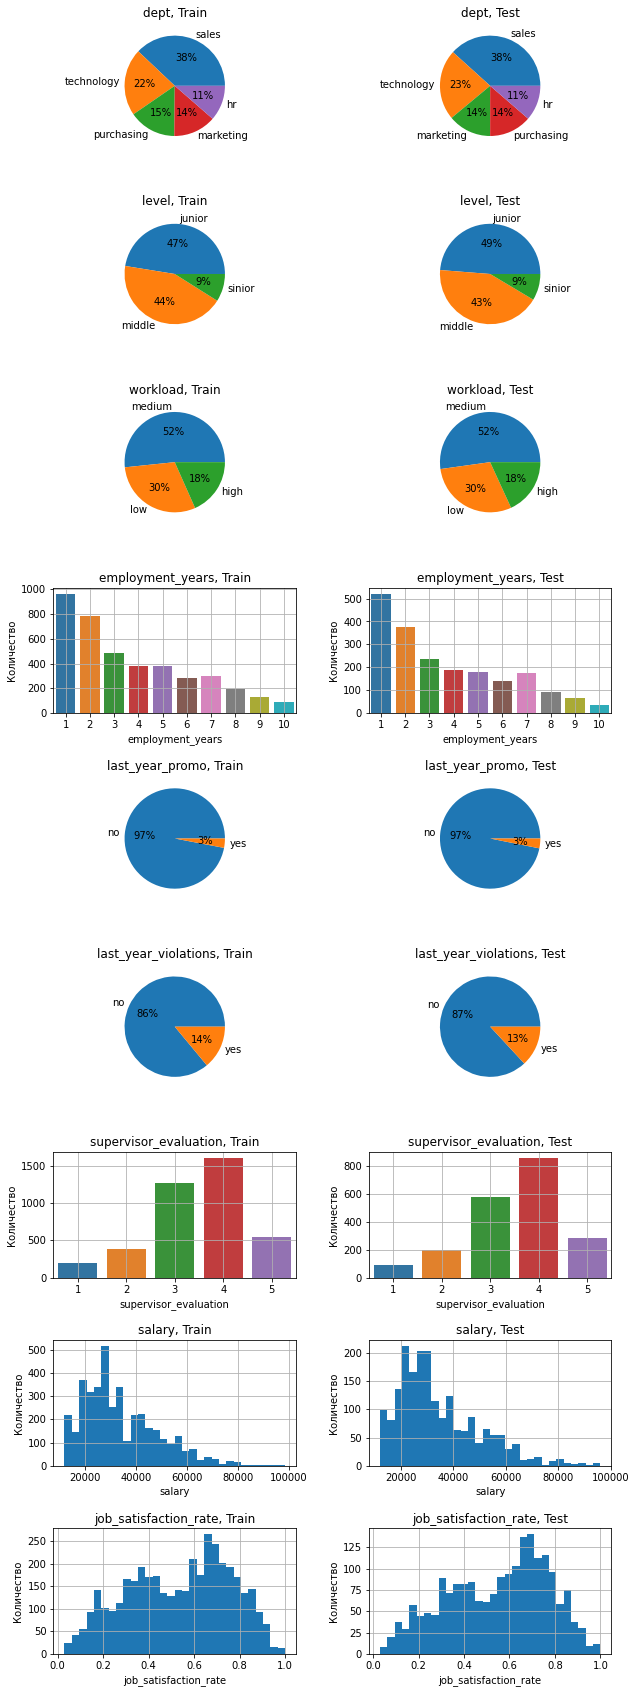

In [29]:
data1 = tables[0]
data2 = pd.merge(tables[1], tables[2], on='id', how='left')
categorial_columns = data1.select_dtypes(exclude='number').columns.tolist()

numerical_columns = data1.select_dtypes(include='number').columns.tolist()
numerical_columns.remove('employment_years')
numerical_columns.remove('supervisor_evaluation')

discrete_columns = ['employment_years', 'supervisor_evaluation']

df_columns = data1.columns.tolist()
df_columns.remove('id')
#print(df_columns)

fig = plt.figure(figsize=(10, 30));
for i, column in enumerate(df_columns):
    plt.subplot(len(df_columns), 2, 2*i+1)
    if column in categorial_columns:
        data1[column].value_counts().plot(
    kind= 'pie',
    title= df_columns[i]+', Train',
    autopct = "%.0f%%",
    ylabel= ""
)
    elif column in numerical_columns:
        plt.hist(data1[column], bins=30)
        plt.title(df_columns[i]+', Train')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
        
    else:
        sns.countplot(data=data1, x=column)
        plt.title(df_columns[i]+', Train')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
        
    plt.subplot(len(df_columns), 2, 2*i+2)
    if column in categorial_columns:
        data2[column].value_counts().plot(
    kind= 'pie',
    title= df_columns[i]+', Test',
    autopct = "%.0f%%",
    ylabel= ""
)
    elif column in numerical_columns:
        plt.hist(data2[column], bins=30)
        plt.title(df_columns[i]+', Test')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
    else:
        sns.countplot(data=data2, x=column)
        plt.title(df_columns[i]+', Test')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show();

Можем видеть, что распределения признаков почти идентичны на тренировочной и на тестовой выборках.

Ни в одном из признаков нет выбросов, в некоторых признаках есть редкие значения (`salary` > 80000 редко встречается, люди с оценкой руководителя 1 балл), но эти значения нужно учитывать.

In [30]:
tables[0].head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [31]:
interval_cols = ['salary', 'job_satisfaction_rate']

`Анализ корреляций тренировочной выборки`

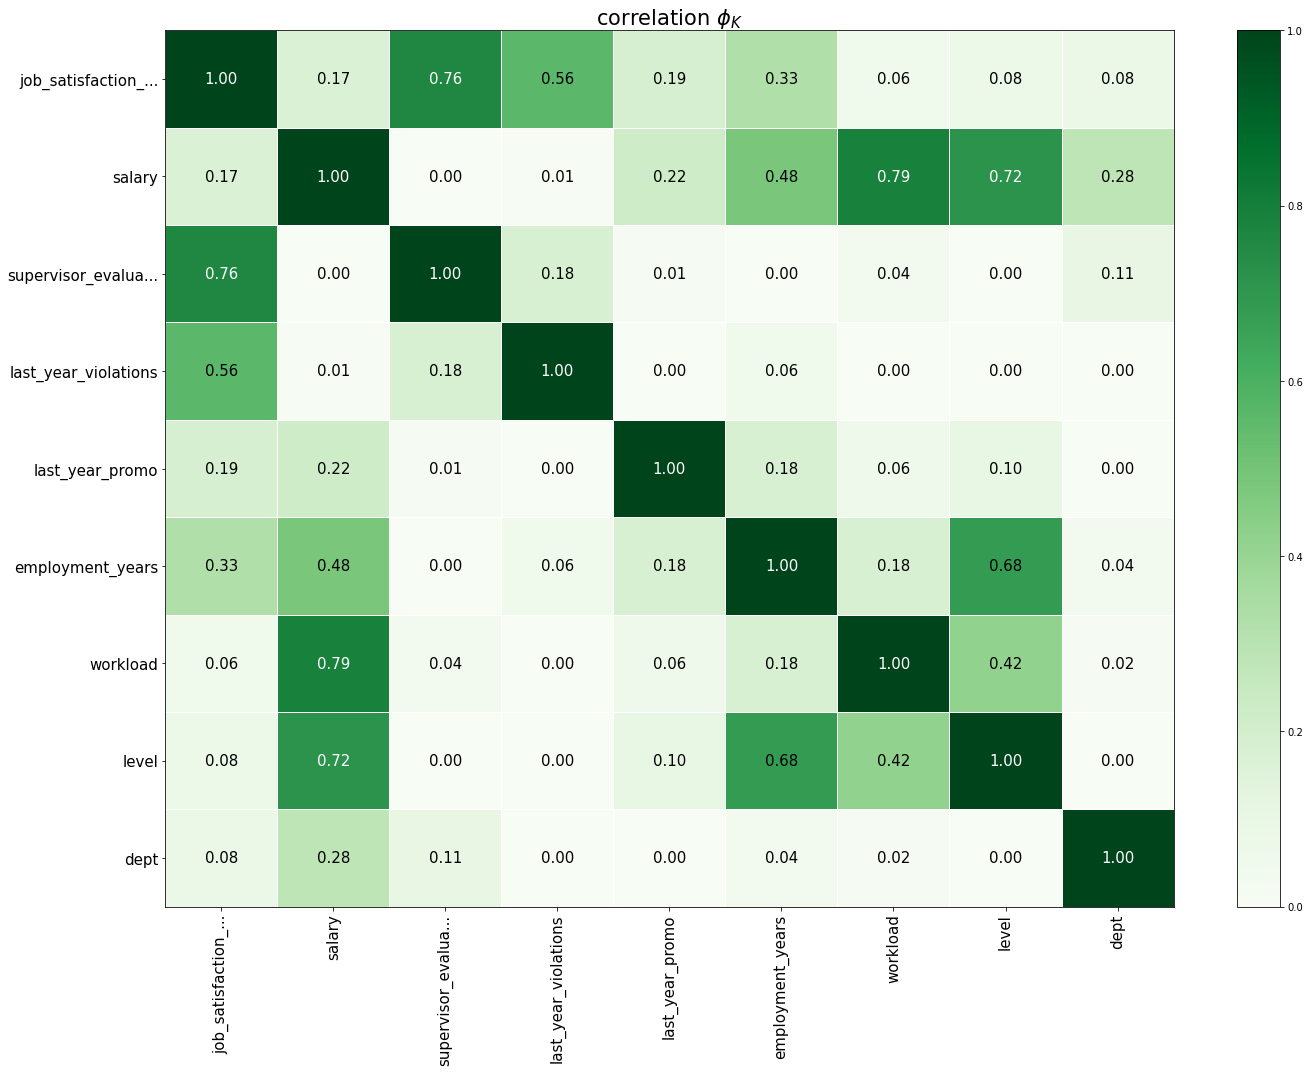

In [32]:
phik_overview = phik_matrix(tables[0].drop(['id'], axis=1), interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Нет коллинеарности признаков (максимальная корреляция 0,79).

Целевой признак `job_satisfaction_rate` наиболее скоррелирован с `supervisor_evaluation` (корреляция 0,76) и `last_year_violations` (корреляция 0,56), с остальными признаками корреляция низкая.

`Анализ корреляций тестовой выборки`

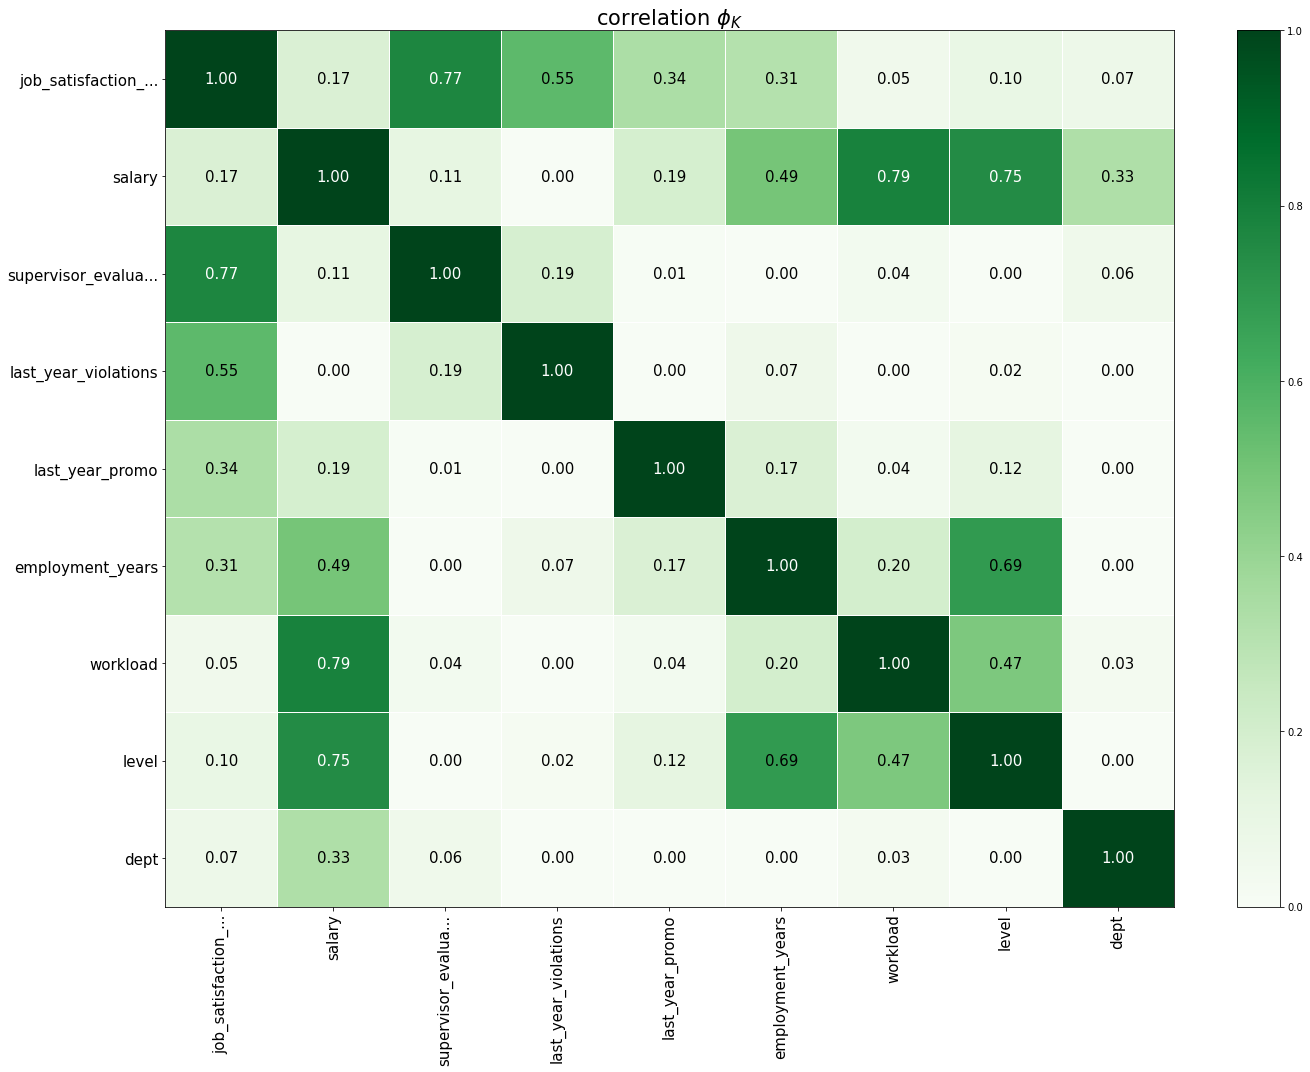

In [33]:
data = pd.merge(tables[1], tables[2], on='id', how='left')
data = data.drop(columns='id')
phik_overview = phik_matrix(data, interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Таблица корреляций для тестовой выборки почти идентичная аналогичной для тренировочной. 

Тут также нет коллинеарности (максимальное значение корреляции в 0,79)

Целевой признак `job_satisfaction_rate` наиболее скоррелирован с `supervisor_evaluation` (корреляция 0,77) и `last_year_violations` (корреляция 0,55), с остальными признаками корреляция низкая.

`Вывод Задача 1 Шаг 3`:

Распределения признаков были изучены на наличие выбросов, редких значений и сильных отличий в значениях признаков между выборками. В данных нет выбросов и редких значений, распределения признаков почти идентичины для выборок, данные готовы к обучению модели.

Количественные признаки необходимо скалировать. Качественных порядковых в данных таблицах нет, так что используем OneHotEncoder.

### Подготовка данных

In [34]:
display(test_features[(test_features['dept'] == ' ') | (test_features['workload'] == ' ')])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


In [35]:
tables = [train_job_satisfaction_rate, test_features, test_target_job_satisfaction_rate]
table_names = ['train_job_satisfaction_rate', 'test_features', 'test_target_job_satisfaction_rate']
for i, table in enumerate(tables):
    print(table_names[i])
    for column in table.columns.tolist():
        if column in table.select_dtypes(exclude='number').columns.to_list():
            print(column)
            print(table[column].unique())
    print('\n')

train_job_satisfaction_rate
dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'high' 'low']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


test_features
dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'low' 'high' ' ']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


test_target_job_satisfaction_rate




In [36]:
table_train = train_job_satisfaction_rate
table_test = pd.merge(test_features, test_target_job_satisfaction_rate, how='left', on='id')

In [37]:
table_train = table_train.drop(columns=['id'])

Могли появиться явные дупликаты, проверим их наличие

In [38]:
table_train.duplicated().sum()

245

Дупликаты присутствуют, удалим их

In [39]:
print(table_train.shape)

(4000, 9)


In [40]:
table_train = table_train.drop_duplicates()

In [41]:
print(table_train.shape)

(3755, 9)


In [42]:
X_train = table_train.drop(columns=['job_satisfaction_rate'])
y_train = table_train['job_satisfaction_rate']
X_test = table_test.drop(columns=['job_satisfaction_rate', 'id'])
y_test = table_test['job_satisfaction_rate']

In [43]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3755, 8) (2000, 8)
(3755,) (2000,)


Пайплайн для подготовки данных

In [44]:
ohe_columns = X_train.select_dtypes(exclude='number').columns.tolist()
ohe_columns.remove('workload')
ohe_columns.remove('level')
ord_columns = ['workload', 'level']

In [45]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()

In [46]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

preprocessor = Pipeline([
    ('preprocessor', data_preprocessor)
])

`Вывод Задача 1 Шаг 4`:



### Обучение моделей

In [47]:
RANDOM_STATE = 42

In [48]:
def SMAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    answer = (100 / len(y_true)) * 2 * sum(abs(y_true - y_pred) / (abs(y_true) + abs(y_pred)))
    return answer

In [49]:
scorer = make_scorer(SMAPE, greater_is_better = False) 

In [50]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [1]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели LinearRegression() 
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    
    #словарь для Dummy-модели
    {
        'models': [DummyRegressor()],
        'preprocessor__num': ['passthrough']   
    }
    
    
    
]

NameError: name 'DecisionTreeRegressor' is not defined

In [52]:
searcher = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer,
    #random_state=RANDOM_STATE,
    n_jobs=-1,
    #n_iter=10
)

In [53]:
''';
searcher = OptunaSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_trials=20
) 
''';

In [54]:
warnings.filterwarnings("ignore")

In [55]:
searcher.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', searcher.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -1 * searcher.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer1_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer2_ohe',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                              

In [56]:
y_pred = searcher.predict(X_test)

print('Значение метрики SMAPE =', SMAPE(y_test, y_pred))

Значение метрики SMAPE = 13.965381144871992


In [57]:
result = pd.DataFrame(searcher.cv_results_)
display(result.sort_values(by='rank_test_score').head(5))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
547,0.025053,0.000420,0.008314,0.000207,"DecisionTreeRegressor(max_depth=12, max_featur...",12,8,passthrough,"{'models': DecisionTreeRegressor(max_depth=12,...",-15.104660,-15.462109,-16.114746,-16.333606,-15.475273,-15.698079,0.454967,1
551,0.024816,0.000540,0.008406,0.000648,"DecisionTreeRegressor(max_depth=12, max_featur...",12,9,passthrough,"{'models': DecisionTreeRegressor(max_depth=12,...",-15.466981,-14.809505,-16.291612,-16.694858,-15.287576,-15.710106,0.686529,2
545,0.027027,0.000482,0.009397,0.000109,"DecisionTreeRegressor(max_depth=12, max_featur...",12,8,MinMaxScaler(),"{'models': DecisionTreeRegressor(max_depth=12,...",-15.104660,-15.488321,-16.114746,-16.343751,-15.499187,-15.710133,0.452875,3
549,0.027453,0.000601,0.009332,0.000264,"DecisionTreeRegressor(max_depth=12, max_featur...",12,9,MinMaxScaler(),"{'models': DecisionTreeRegressor(max_depth=12,...",-15.466981,-14.829926,-16.342877,-16.709501,-15.203927,-15.710642,0.705582,4
546,0.027948,0.000744,0.009803,0.000568,"DecisionTreeRegressor(max_depth=12, max_featur...",12,8,RobustScaler(),"{'models': DecisionTreeRegressor(max_depth=12,...",-15.169281,-15.416519,-16.144847,-16.342828,-15.505754,-15.715846,0.449359,5


`Вывод Задача 1 Шаг 5`:

Лучшей оказалась модель дерева решений с параметрами `max_depth`= 12 и `max_features`= 8. Она показала значение метрики SMAPE на тесте, равное 14, что приемлемо.

### Оформление выводов

`Вывод Задача 1 Шаг 6`:

Наилучшей для данной задачи оказалась модель дерева решений (соревновалась с линейной регрессией). Линейная регрессия показала себя хуже, так как зависимости между целевым признаком и измеряемыми нелинейные.

## Задача 2

### Загрузка данных

Загружаем файлы

In [ ]:
train_quit = pd.read_csv('./train_quit.csv')
test_features = pd.read_csv('./test_features.csv')
test_target = pd.read_csv('./test_target_quit.csv')

In [59]:
print(train_quit.shape)
print(test_features.shape)
print(test_target.shape)

(4000, 10)
(2000, 9)
(2000, 2)


Выводим первые строки

In [60]:
display(train_quit.head())
display(test_features.head())
display(test_target.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


`Вывод Задача 2 Шаг 1`:

Загрузили 3 таблицы.

### Предобработка данных

Вывод уникальных значений каждого столбца

In [61]:
tables = [train_quit, test_features, test_target]
table_names = ['train_quit', 'test_features', 'test_target']

for i, table in enumerate(tables):
    print(table_names[i])
    for column in table.columns.tolist():
        if column in table.select_dtypes(exclude='number').columns.to_list():
            print(column)
            print(table[column].unique())
    print('\n')

train_quit
dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']
level
['middle' 'junior' 'sinior']
workload
['high' 'medium' 'low']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']
quit
['no' 'yes']


test_features
dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'low' 'high' ' ']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


test_target
quit
['yes' 'no']




Присутствуют пропущенные значения вида np.nan и ' '. Неявных дупликатов нет.

In [62]:
print(tables[0].duplicated().sum())
print(tables[1].duplicated().sum())

0
0


Нет явных дупликатов

Проверка типов данных в столбцах

In [63]:
tables[0].head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no


In [64]:
tables[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [65]:
tables[1].head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200


In [66]:
tables[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Все типы верные

`Вывод Задача 2 Шаг 2`:

В данных были обнаружены пропуски в виде NaN или пробелов, они будут обрабатываться в итоговом пайплайне. Явных дупликатов нет, все столбцы имеют верный тип данных.

### Исследовательский анализ данных

In [67]:
train_df = train_quit.drop(columns=['id'])
test_df = pd.merge(test_features, test_target, how='left', on='id')
test_df = test_df.drop(columns=['id'])
X_train = train_df.drop(columns=['quit'])
y_train = train_df['quit']
X_test = test_df.drop(columns=['quit'])
y_test = test_df['quit']

In [68]:
train_df.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,sales,middle,high,2,no,no,4,54000,no
1,sales,junior,medium,2,no,no,4,27600,no
2,purchasing,middle,medium,5,no,no,1,37200,no
3,sales,junior,medium,2,no,yes,3,24000,yes
4,marketing,junior,medium,2,no,no,5,25200,no


In [69]:
test_df.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,marketing,junior,medium,2,no,no,5,28800,no
1,hr,junior,medium,1,no,no,4,30000,no
2,sales,middle,low,5,no,no,4,19200,no
3,sales,middle,low,6,no,no,4,19200,no
4,hr,middle,medium,5,no,no,5,40800,no


Распределение признаков в тренировочной выборке

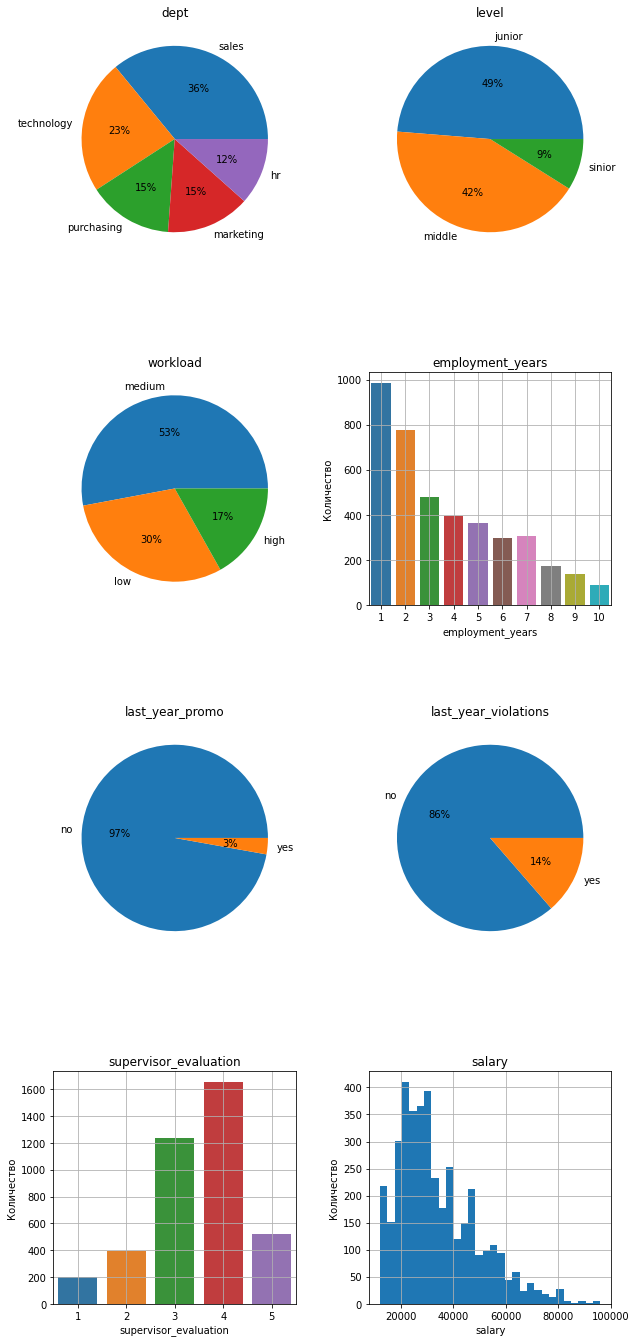

In [70]:
data = train_df
categorial_columns = train_df.select_dtypes(exclude='number').columns.tolist()

numerical_columns = train_df.select_dtypes(include='number').columns.tolist()
numerical_columns.remove('employment_years')
numerical_columns.remove('supervisor_evaluation')

discrete_columns = ['employment_years', 'supervisor_evaluation']

df_columns = train_df.columns.tolist()
df_columns.remove('quit')
#print(df_columns)

fig = plt.figure(figsize=(10, 30));
for i, column in enumerate(df_columns):
    plt.subplot(len(df_columns)//2+1, 2, i+1)
    if column in categorial_columns:
        data[column].value_counts().plot(
    kind= 'pie',
    title= df_columns[i],
    autopct = "%.0f%%",
    ylabel= ""
)
    elif column in numerical_columns:
        plt.hist(data[column], bins=30)
        plt.title(df_columns[i])
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
        
    else:
        sns.countplot(data=data, x=column)
        plt.title(df_columns[i])
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show();

Выбросов нет, редкое значение есть только в столбце `last_year_promo`, что закономерно

Вывод распределений признаков для уволившихся сотрудников и оставшихся в компании.

In [71]:
print(y_train.value_counts())
print(y_test.value_counts())

no     2872
yes    1128
Name: quit, dtype: int64
no     1436
yes     564
Name: quit, dtype: int64


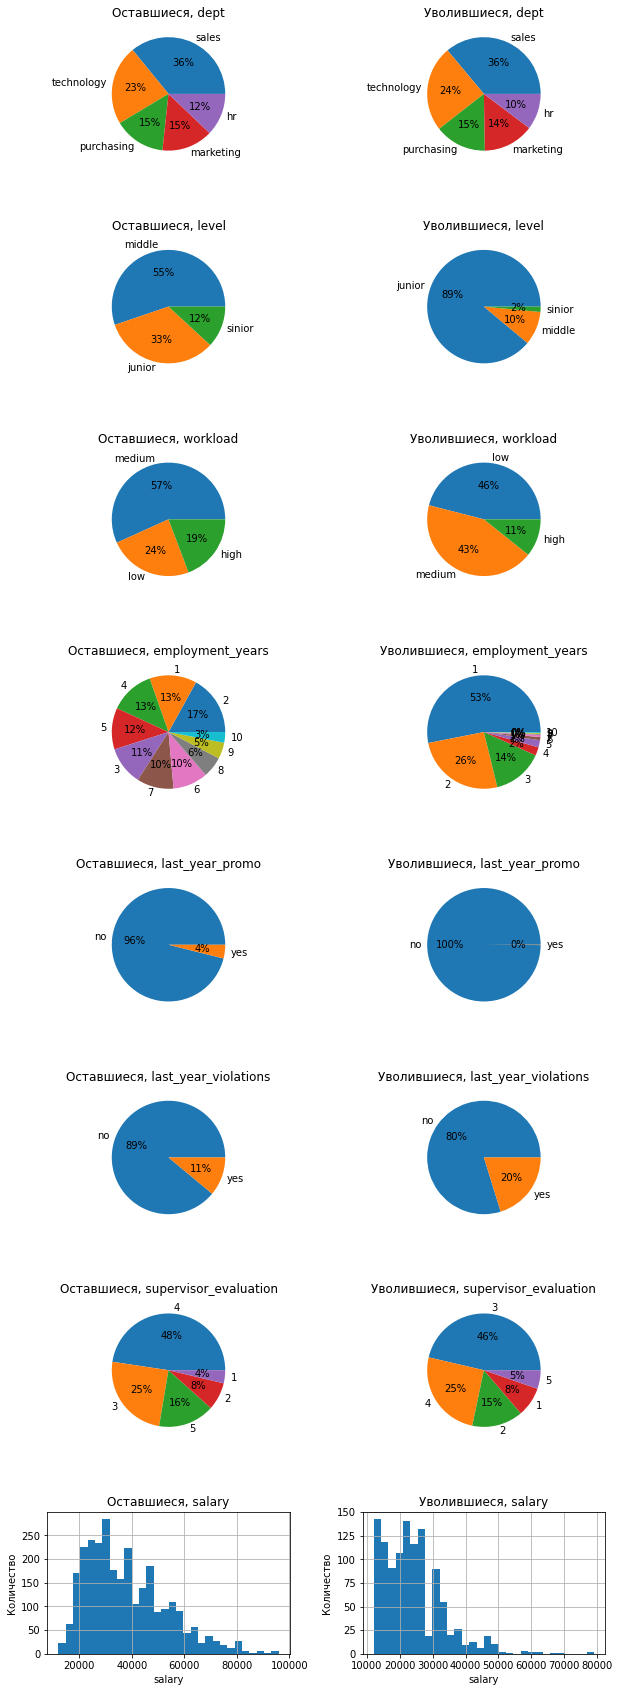

In [72]:
data1 = train_df.loc[train_df['quit'] == 'no']
data2 = train_df.loc[train_df['quit'] == 'yes']
categorial_columns = train_df.select_dtypes(exclude='number').columns.tolist()

numerical_columns = train_df.select_dtypes(include='number').columns.tolist()
numerical_columns.remove('employment_years')
numerical_columns.remove('supervisor_evaluation')

discrete_columns = ['employment_years', 'supervisor_evaluation']

df_columns = train_df.columns.tolist()
df_columns.remove('quit')
#print(df_columns)

fig = plt.figure(figsize=(10, 30));
for i, column in enumerate(df_columns):
    plt.subplot(len(df_columns), 2, 2*i+1)
    if column in (categorial_columns+discrete_columns):
        data1[column].value_counts().plot(
    kind= 'pie',
    title= 'Оставшиеся, '+df_columns[i],
    autopct = "%.0f%%",
    ylabel= ""
)
    elif column in numerical_columns:
        plt.hist(data1[column], bins=30)
        plt.title('Оставшиеся, '+df_columns[i])
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
        
    else:
        sns.countplot(data=data1, x=column)
        plt.title('Оставшиеся, '+df_columns[i])
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
        
    plt.subplot(len(df_columns), 2, 2*i+2)
    if column in (categorial_columns+discrete_columns):
        data2[column].value_counts().plot(
    kind= 'pie',
    title= 'Уволившиеся, '+df_columns[i],
    autopct = "%.0f%%",
    ylabel= ""
)
    elif column in numerical_columns:
        plt.hist(data2[column], bins=30)
        plt.title('Уволившиеся, '+df_columns[i])
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
    else:
        sns.countplot(data=data2, x=column)
        plt.title('Уволившиеся, '+df_columns[i])
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show();

* `dept` - увольняются равномерно из всех отделов
* `level` - 90% уволившихся уровня `junior`
* `workload ` - намного больше слабозагруженных сотрудников, чем среди оставшихся в компании
* `employment_years` - почти все работали не более 3 лет
* `last_year_promo` - практически не получают повышения
* `last_year_violations` - чуть больше нарущают договор, чем оставшиеся в компании
* `supervisor_evaluation` - самая частая оценка - 3
* `salary` - от 15 до 40 тыс. р. со средним около 25 т.р.

In [73]:
X_train.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary'],
      dtype='object')

In [74]:
test_df = pd.merge(test_features, test_target, how='left', on='id')

big_test_df = pd.merge(test_df, test_target_job_satisfaction_rate, \
                       how='left', on='id')

In [75]:
display(big_test_df.head(3))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.72
2,467458,sales,middle,low,5,no,no,4,19200,no,0.64


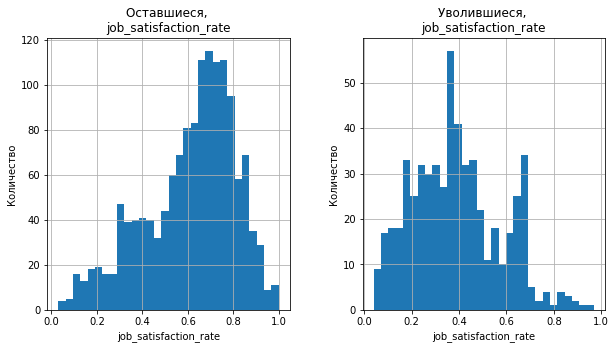

In [76]:
column = 'job_satisfaction_rate'
data1 = big_test_df.loc[big_test_df['quit'] == 'no', column]
data2 = big_test_df.loc[big_test_df['quit'] == 'yes', column]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
if column in categorial_columns:
    data1.value_counts().plot(
kind= 'pie',
title= 'Оставшиеся, \n' + column,
autopct = "%.0f%%",
ylabel= ""
)
else:
    plt.hist(data1, bins=30)
    plt.title('Оставшиеся, \n' + column)
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.grid()

plt.subplot(1, 2, 2)
if column in categorial_columns:
    data2.value_counts().plot(
kind= 'pie',
title= 'Уволившиеся, \n' + column,
autopct = "%.0f%%",
ylabel= ""
)
else:
    plt.hist(data2, bins=30)
    plt.title('Уволившиеся, \n' + column)
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.grid()
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

Сравним распределения с помощью t-теста

$H_0$: средние значения распределений равны: $\mu_1 = \mu_2$

$H_1$: средние значения распределений различны: $\mu_1 \neq \mu_2$

In [77]:
column = 'salary'
data1 = big_test_df.loc[big_test_df['quit'] == 'no', column]
data2 = big_test_df.loc[big_test_df['quit'] == 'yes', column]
result = ttest_ind(data1, data2, equal_var=False)
print('Значение статистики =', result.statistic)
print('p-значение =', result.pvalue)

Значение статистики = 20.90492671550031
p-значение = 2.79197413132201e-85


Имеем сильное различие распределений

`Вывод Задача 2 Шаг 3`:

Портрет уволившегося:
* Уровень `junior`
* Работает не более трёх лет
* Не получал повышения в течении года
* Оценка 3 от руководителя
* З/П от 15 до 40 тыс. р.


### Добавление нового входного признака

Предсказываем признак и добавляем его в модель

In [78]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,marketing,junior,medium,2,no,no,5,28800
1,hr,junior,medium,1,no,no,4,30000
2,sales,middle,low,5,no,no,4,19200
3,sales,middle,low,6,no,no,4,19200
4,hr,middle,medium,5,no,no,5,40800


In [79]:
y_pred_train = searcher.predict(X_train)
X_train['job_satisfaction_rate'] = y_pred_train

y_pred_test = searcher.predict(X_test)
X_test['job_satisfaction_rate'] = y_pred_test

display(X_train.head(3))
display(X_test.head(3))
display(y_train.head(3))
display(y_test.head(3))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.635385
1,sales,junior,medium,2,no,no,4,27600,0.847143
2,purchasing,middle,medium,5,no,no,1,37200,0.358182


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.830000
1,hr,junior,medium,1,no,no,4,30000,0.677500
2,sales,middle,low,5,no,no,4,19200,0.654286


0    no
1    no
2    no
Name: quit, dtype: object

0    no
1    no
2    no
Name: quit, dtype: object

In [80]:
display(y_train.value_counts())
display(y_test.value_counts())

no     2872
yes    1128
Name: quit, dtype: int64

no     1436
yes     564
Name: quit, dtype: int64

`Вывод Задача 2 Шаг 4`:

Добавили в тренировочные данные признак `job_satisfaction_rate`, предсказанный лучшей моделью из прошлой задачи

### Подготовка данных

`Выберем наиболее информативные признаки`

Для тренировочной выборки

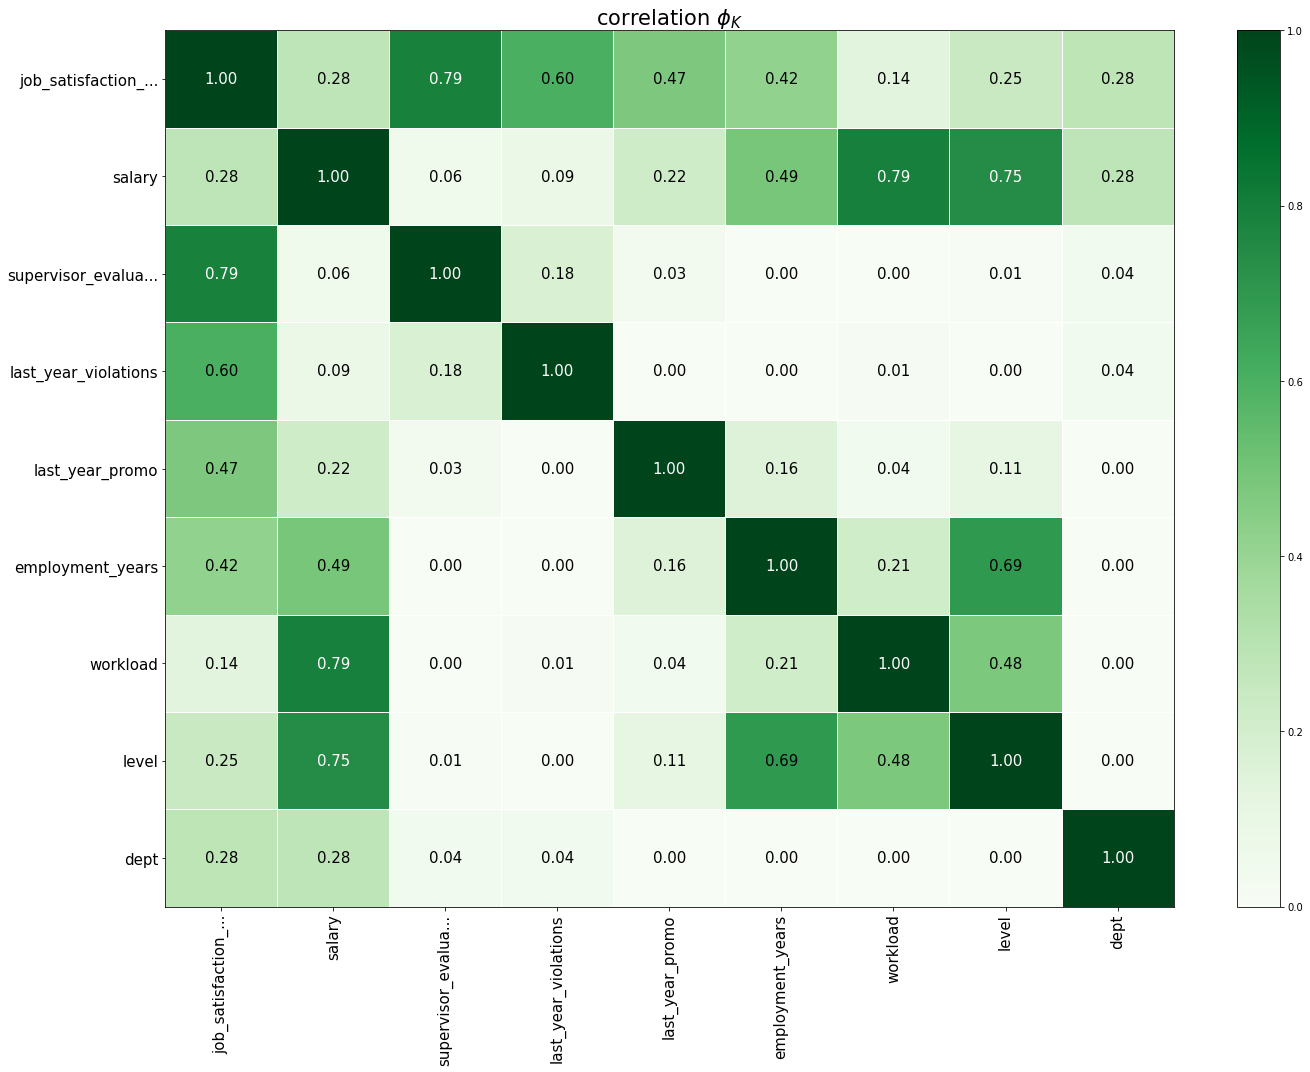

In [81]:
data = X_train
phik_overview = phik_matrix(data, interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Для тестовой выборки

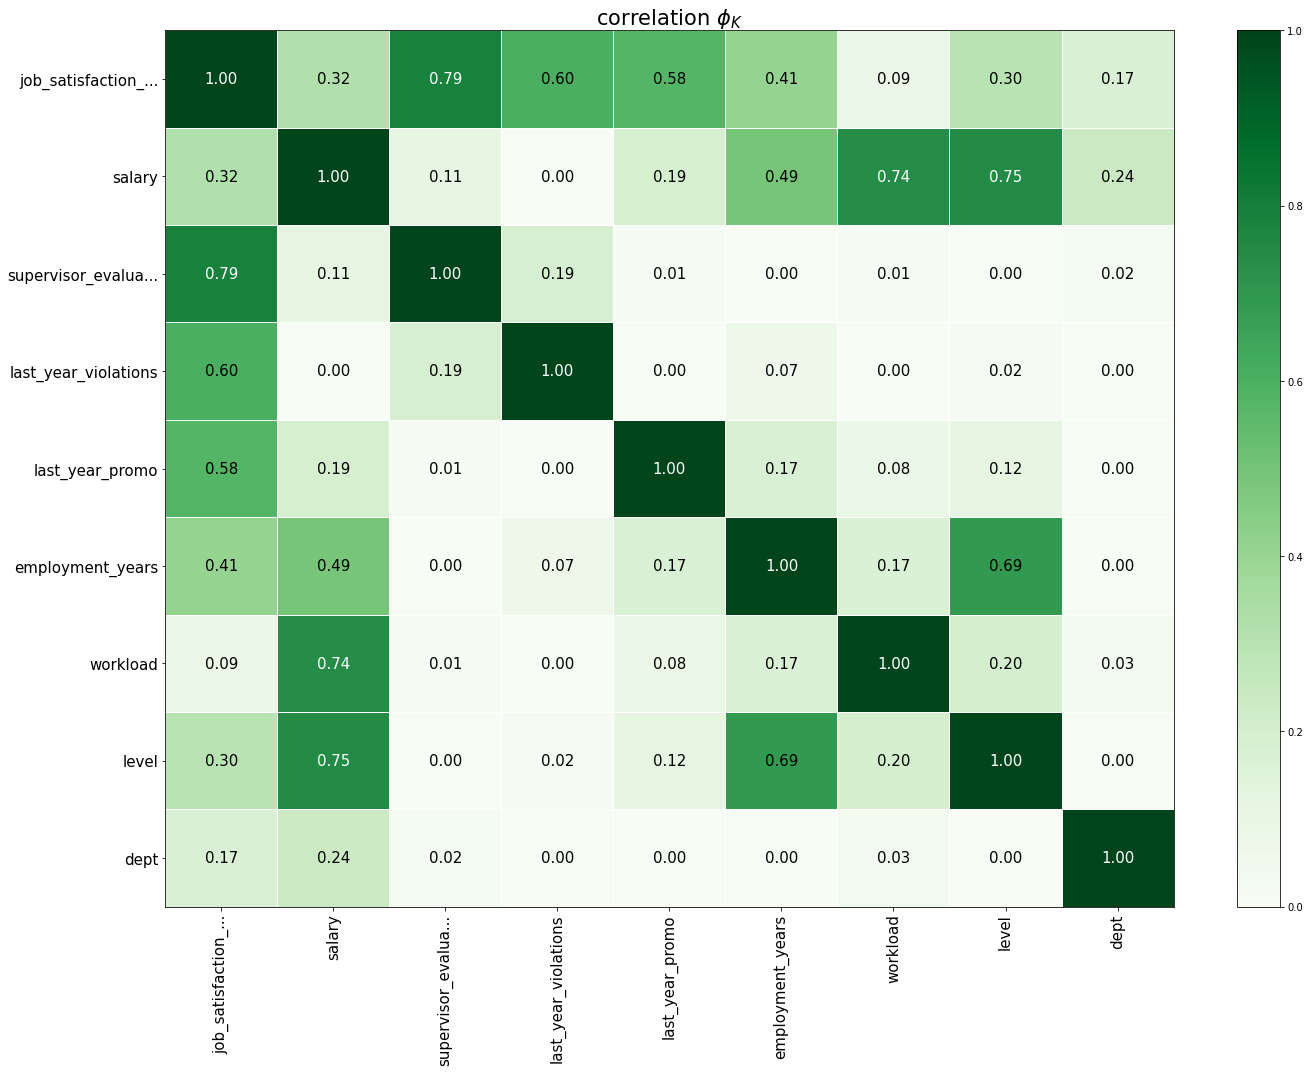

In [82]:
data = X_test
phik_overview = phik_matrix(data, interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Не будем брать в модель признаки `workload` и `dept`, т.к. они наимениие скоррелированы с целевым.

In [83]:
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.635385
1,sales,junior,medium,2,no,no,4,27600,0.847143
2,purchasing,middle,medium,5,no,no,1,37200,0.358182
3,sales,junior,medium,2,no,yes,3,24000,0.380000
4,marketing,junior,medium,2,no,no,5,25200,0.690000


In [84]:
ohe_columns = X_train.select_dtypes(exclude='number').columns.tolist()
ohe_columns.remove('workload')
ohe_columns.remove('level')
ohe_columns.remove('dept')
ord_columns = ['workload', 'level']
#ord_columns = ['level']
num_columns = X_train.select_dtypes(include='number').columns.tolist()
print(ohe_columns)
print(ord_columns)
print(num_columns)

['last_year_promo', 'last_year_violations']
['workload', 'level']
['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


In [85]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
     ('simpleImputer1_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer2_ohe', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )


In [86]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_before_ord2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[ 
                    ['low', 'medium', 'high'],
                    ['junior', 'medium', 'sinior']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [87]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

preprocessor = Pipeline([
    ('preprocessor', data_preprocessor)
])

`Вывод Задача 2 Шаг 5`:



### Обучение модели

In [88]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [89]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': [10**i for i in range(-3, 4)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(kernel='linear', probability=True,
            random_state=RANDOM_STATE
        )],
        'models__C': [10**i for i in range(-3, 4)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для DummyClassifier()
    {
        'models': [DummyClassifier()],
        'preprocessor__num': ['passthrough']  
    }
]

In [90]:
searcher2 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50
)

In [91]:
display(X_train.head(3))
display(X_test.head(3))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.635385
1,sales,junior,medium,2,no,no,4,27600,0.847143
2,purchasing,middle,medium,5,no,no,1,37200,0.358182


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.830000
1,hr,junior,medium,1,no,no,4,30000,0.677500
2,sales,middle,low,5,no,no,4,19200,0.654286


In [92]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 9)
(2000, 9)
(4000,)
(2000,)


In [93]:
columns = ohe_columns + ord_columns + num_columns
searcher2.fit(X_train[columns], y_train)

print('Лучшая модель и её параметры:\n\n', searcher2.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', searcher2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer1_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer2_ohe',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                              

In [94]:
probas = searcher2.predict_proba(X_test[columns])[:, 1]

print('Значение метрики roc-auc', roc_auc_score(y_test, probas))

Значение метрики roc-auc 0.9163141557517926


In [95]:
results = pd.DataFrame(searcher2.cv_results_)
display(results.sort_values(by='rank_test_score').head(5))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__C,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
38,0.029099,0.000512,0.012428,0.000585,RobustScaler(),6,6,"DecisionTreeClassifier(max_depth=6, max_featur...",NaN,NaN,"{'preprocessor__num': RobustScaler(), 'models_...",0.930562,0.925202,0.922840,0.921911,0.933763,0.926856,0.004577,1
26,0.028527,0.000641,0.031705,0.001112,MinMaxScaler(),NaN,NaN,KNeighborsClassifier(),NaN,6,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.917032,0.929086,0.914696,0.918149,0.929840,0.921760,0.006391,2
13,0.028045,0.000642,0.019273,0.000358,RobustScaler(),NaN,NaN,KNeighborsClassifier(),NaN,6,"{'preprocessor__num': RobustScaler(), 'models_...",0.913310,0.923598,0.919171,0.917853,0.932036,0.921194,0.006336,3
16,0.027144,0.000542,0.030194,0.000555,MinMaxScaler(),NaN,NaN,KNeighborsClassifier(),NaN,5,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.914555,0.924128,0.914152,0.913655,0.928286,0.918955,0.006072,4
43,0.028299,0.000754,0.012696,0.000497,StandardScaler(),4,5,"DecisionTreeClassifier(max_depth=6, max_featur...",NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.910794,0.907614,0.920254,0.917351,0.938223,0.918847,0.010683,5


`Вывод Задача 2 Шаг 6`:

Наилучшей оказалась модель логистической регрессии с параметром регуляризации равным 10. Значение её метрики `roc-auc` на тестовой выборке равно 0.916.

### Выводы

`Вывод Задача 2 Шаг 7`:



Наилучшей оказалась модель логистической регрессии с параметром регуляризации равным 10. Значение её метрики roc-auc на тестовой выборке равно 0.9.

## Общий вывод

Исследовались данные компании «Работа с заботой» об их сотрудниках. Требовалось разработать модель для предсказания степени удовлетворенности сотрудников своей работой, а также вторую модель для предсказания того, уволится сотрудник или нет. В данных присутствовала информация об отделе, должности, уровне загруженности, длительность работы, повышении, нарушениях, оценке от руководителя и зарплате некоторых сотрудников компании.

Для построения первой модели данные были предобработаны, исследованы на наличие редких значений и выбросов. Для выбора лучшей модели регрессии был разработан пайплайн, в котором обучалось 2 вида моделей с разными значениями гиперпараметров. Лучшей моделью по метрике sMAPE (symmetric mean absolute percentage error) оказалось дерево решений с гиперпараметрами `max_depth=12`, `max_features=8` со значением метрики на тестовой выборке, равным 14. 
 
Для построения второй модели также была проведена предобработка данных и дальнейшее исследование для выявления редких значений и выбросов, которые не были обнаружены. Для нахождения лучшей модели также использовался пайплайн, на этот раз содержащий 4 вида моделей - дерева решений, логистической регрессии, опорных векторов и k ближайших соседей с варьирующимися значениями гиперпараметров. Лучшей по итогам работы пайплайна оказалась модель логистической регрессии с параметром регуляризации, равным 10. Она показалась значения метрики `roc-auc=0.916`.

Для прогнозирования того, уволятся ли сотрудники компании рекомендуется использовать разработанные модели. На первом этапе собирается максимально возможно количество данных об удовлетворенности сотрудников их работой. На втором этапе для сотрудников, информацию об удовлетворенности которых собрать не удалось, прогнозируются эти значения с помощью разработанной модели регрессии. На третьем и последним этапе по данным о сотрудниках а также по их удовлетворенности работой (измеренной или предсказаной) с помощью разработанной модели классификации прогнозируется, уйдет сотрудник или нет.

Для снижения уровня увольнений рекомендуется сотрудникам, для которых модель предсказала, что они уволятся, улучшать условия труда. Например можно повысить зарплату, дать возможность повышения или дать возможность перевода в другой отдел.